In [3]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from textwrap import wrap
import re
import tensorflow as tf
from pickle import dump, load
from tqdm import tqdm
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate
from tensorflow.keras.models import Model

In [4]:
images_path = '../input/ms-coco-dataset/train2014/train2014'
captions_path = '../input/ms-coco-dataset/captions/annotations/captions_train2014.json'

In [5]:
json_file = json.load(open(captions_path))

In [6]:
captions_df = pd.DataFrame(json_file['annotations'])
captions_df = captions_df[['image_id', 'caption']]

In [7]:
images_df = pd.DataFrame(json_file['images'])
images_df = images_df[['file_name', 'id']]
images_df = images_df.rename(columns={'id':'image_id'})

In [8]:
df = pd.merge(images_df, captions_df, how="left", on=["image_id"])
df = df.drop(['image_id'], axis=1)
df['file_name'] = images_path + "/" + df['file_name']
df = df.drop_duplicates(subset=['file_name'])
df = df.drop_duplicates(subset=['caption'])
df.head()

,file_name,caption
0,../input/ms-coco-dataset/train2014/train2014/C...,A restaurant has modern wooden tables and chairs.
5,../input/ms-coco-dataset/train2014/train2014/C...,A man preparing desserts in a kitchen covered ...
10,../input/ms-coco-dataset/train2014/train2014/C...,a big red telephone booth that a man is standi...
15,../input/ms-coco-dataset/train2014/train2014/C...,the kitchen is full of spices on the rack
20,../input/ms-coco-dataset/train2014/train2014/C...,A child and woman are cooking in the kitchen.


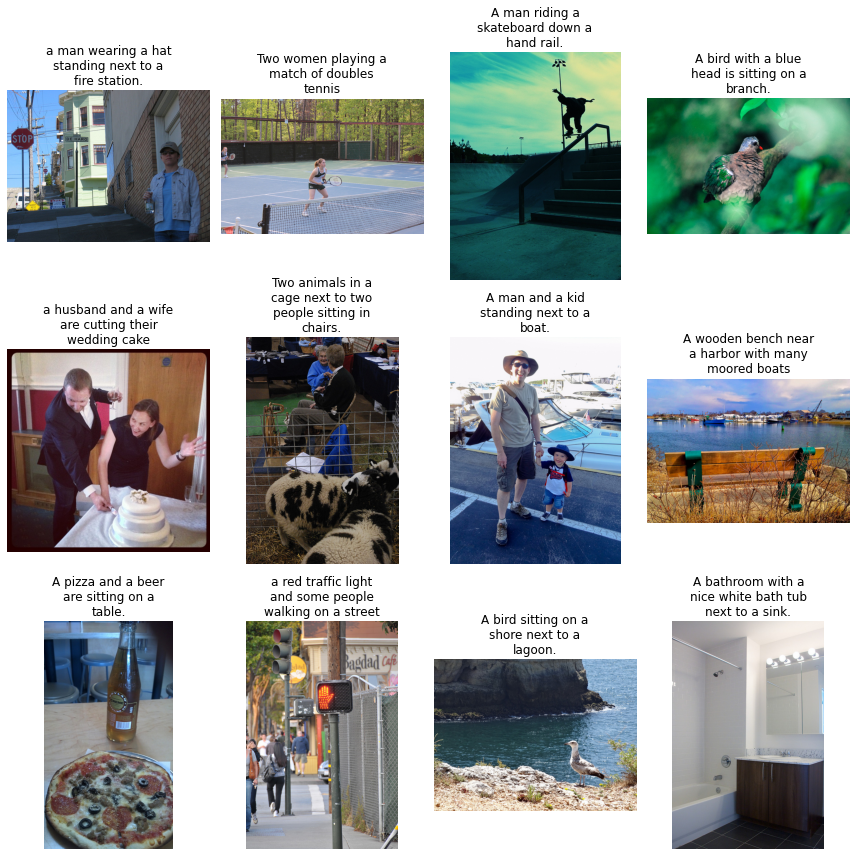

In [9]:
sample_df = df.sample(12)
files = sample_df['file_name'].tolist()
caption_list = sample_df['caption'].tolist()

nrows = 3
ncols = 4
fig = plt.gcf()
fig.set_size_inches(nrows * 4, nrows * 4)

for i, (img_path, caption) in enumerate(zip(files, caption_list)):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title('\n'.join(wrap(caption, 20)))

plt.tight_layout()
plt.show()

In [10]:
df = df.sample(2500, random_state=100)
train = df[:2000]
test = df[2000:]
train.shape, test.shape

((2000, 2), (500, 2))

In [11]:
df

,file_name,caption
244387,../input/ms-coco-dataset/train2014/train2014/C...,a man standing at an outdoor table working on ...
257622,../input/ms-coco-dataset/train2014/train2014/C...,A man is tending to a couple of sheep
22855,../input/ms-coco-dataset/train2014/train2014/C...,A elephant with tusks is standing in the grass.
4792,../input/ms-coco-dataset/train2014/train2014/C...,a blender with mixed fruit sitting in a container
333256,../input/ms-coco-dataset/train2014/train2014/C...,The bathroom has tools all over it and the toi...
...,...,...
291129,../input/ms-coco-dataset/train2014/train2014/C...,A woman is holding a white object with a cord ...
78226,../input/ms-coco-dataset/train2014/train2014/C...,a green train engine is pulling its train cars
138418,../input/ms-coco-dataset/train2014/train2014/C...,A vase of flowers and some scissors in a basket.
241970,../input/ms-coco-dataset/train2014/train2014/C...,a bus driving down a road next to some buildings


In [12]:
def preprocess_caption(text):
    text = text.lower()
    text = re.sub('[^A-Za-z]', ' ', text)
    text = ' '.join([word for word in text.split() if len(word)>1])
    text = 'startseq ' + text + ' endseq'
    return text

In [13]:
train['caption'] = train['caption'].apply(lambda x: preprocess_caption(x))
train.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,file_name,caption
244387,../input/ms-coco-dataset/train2014/train2014/C...,startseq man standing at an outdoor table work...
257622,../input/ms-coco-dataset/train2014/train2014/C...,startseq man is tending to couple of sheep endseq
22855,../input/ms-coco-dataset/train2014/train2014/C...,startseq elephant with tusks is standing in th...
4792,../input/ms-coco-dataset/train2014/train2014/C...,startseq blender with mixed fruit sitting in c...
333256,../input/ms-coco-dataset/train2014/train2014/C...,startseq the bathroom has tools all over it an...


In [14]:
images = train['file_name'].tolist()
captions = train['caption'].tolist()
captions[:10]

['startseq man standing at an outdoor table working on some pizzas endseq',
 'startseq man is tending to couple of sheep endseq',
 'startseq elephant with tusks is standing in the grass endseq',
 'startseq blender with mixed fruit sitting in container endseq',
 'startseq the bathroom has tools all over it and the toilet endseq',
 'startseq woman standing in kitchen with tray of food endseq',
 'startseq train driving on the tracks near trees and water endseq',
 'startseq woman holding large sheet cake while standing next to table endseq',
 'startseq young man standing under white road sign endseq',
 'startseq kitchen cabinet with built in sink and microwave inside it endseq']

In [15]:
len(np.unique(images))

2000

In [16]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)
print('Vocab size:', vocab_size)
print('Max length:', max_length)

Vocab size: 2101
Max length: 35


In [17]:
tf.keras.backend.clear_session()
image_size = 299
cnn_model = Xception(weights=None, input_shape=(image_size,image_size,3), include_top=False)
cnn_model.load_weights('../input/keras-pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

features = {}
for image in tqdm(images):
    img = tf.keras.preprocessing.image.load_img(image, target_size=(image_size, image_size))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255.0
    img = np.expand_dims(img, axis=0)

    feature = cnn_model.predict(img, verbose=0)
    features[image] = feature
    
dump(features, open('xception_features.p','wb'))

2022-11-05 17:04:32.000787: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
100%|██████████| 2000/2000 [09:02<00:00,  3.69it/s]


In [18]:
features = load(open('./xception_features.p', 'rb'))
len(features)

2000

In [19]:
tf.keras.backend.clear_session()
image_size = 299
cnn_model = Xception(weights=None, input_shape=(image_size,image_size,3), include_top=False)
cnn_model.load_weights('../input/keras-pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [20]:
img = tf.keras.preprocessing.image.load_img(images[0], target_size=(image_size, image_size))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255.0
img = np.expand_dims(img, axis=0)

feature = cnn_model.predict(img, verbose=0)

In [21]:
feature.shape

(1, 10, 10, 2048)

In [22]:
def get_model_input(df):
    X_feature, X_seq, y = list(), list(), list()
    images = df['file_name'].tolist()

    for image in images:
        feature = features[image][0]
        captions = df.loc[df['file_name']==image, 'caption'].tolist()
        for caption in captions:
            sequence = tokenizer.texts_to_sequences([caption])[0]

            for i in range(1, len(sequence)):
                in_sequence, out_sequence = sequence[:i], sequence[i]
                in_sequence = tf.keras.preprocessing.sequence.pad_sequences([in_sequence], maxlen=max_length)[0]
                out_sequence = tf.keras.utils.to_categorical([out_sequence], num_classes=vocab_size)[0]
                X_feature.append(feature)
                X_seq.append(in_sequence)
                y.append(out_sequence)

    X_feature, X_seq, y = np.array(X_feature), np.array(X_seq), np.array(y)
    return X_feature, X_seq, y


In [ ]:
train_feature, train_seq, train_y = get_model_input(train.sample(100))
test_feature, test_seq, test_y = get_model_input(test.sample(20))

train_feature.shape, train_seq.shape, train_y.shape

# CNN + LSTM Model for Image Captioning

In [25]:
# CNN output model
tf.keras.backend.clear_session()
input_model_1 = Input(shape=(2048,))
feature_model_1 = Dropout(0.5)(input_model_1)
feature_model_2 = Dense(256, activation='relu')(feature_model_1)

# LSTM  model
input_model_2 = Input(shape=(max_length,))
seq_model_1 = Embedding(vocab_size, 128, mask_zero=True)(input_model_2)
seq_model_2 = Dropout(0.5)(seq_model_1)
seq_model_3 = LSTM(256, activation='relu', return_sequences=True)(seq_model_2)
seq_model_4 = LSTM(256, activation='relu')(seq_model_3)

# Merging both models
decoder_1 = add([feature_model_2, seq_model_4])
decoder_2 = Dense(256, activation='relu')(decoder_1)
output_model = Dense(vocab_size, activation='softmax')(decoder_2)

# [image, seq] [word]
model = Model(inputs=[input_model_1, input_model_2], outputs=output_model)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 128)      268928      input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 35, 128)      0           embedding[0][0]                  
______________________________________________________________________________________________

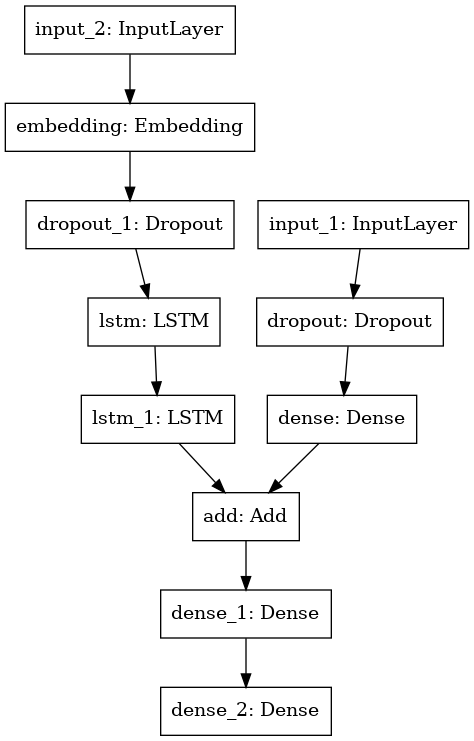

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
history = model.fit((train_feature, train_seq), train_y, epochs=50,
                    validation_data=((test_feature, test_seq), test_y))

In [29]:
def inverse_tokenizer(index):
    for word, i in tokenizer.word_index.items():
        if i==index:
            return word
    return None

def predict_caption(image):
    img_t = image.split('/')[-1]
    feature = features[img_t]
    pred_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([pred_text])[0]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        word = inverse_tokenizer(y_pred)
        if word is None:
            break
        pred_text+= " " + word
        if word == 'endseq':
            break
    return pred_text

In [ ]:
sample_df = test.sample(12)
files = sample_df['file_name'].tolist()
pred_captions = []
for file in files:
    caption = predict_caption(file)
    pred_captions.append(caption)

nrows = 3
ncols = 4
fig = plt.gcf()
fig.set_size_inches(nrows * 4, nrows * 4)

for i, (img_path, target) in enumerate(zip(files, pred_captions)):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title("\n".join(wrap(target, 20)))

plt.tight_layout()
plt.show()